In [84]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

### Load data (pre-processed in clean.ipynb) and define useful constants

In [85]:
# load data
# res = pd.read_csv("results/results_cleaned.csv")
res = pd.read_csv("results/results_cleaned_no_outliers.csv")

# required fields
ids = ['timestamp','postId','workerId','mode']

# interactions
inter = ['timestamp','postId','workerId','mode','interaction','UrlChanges', 'highUrlChanges', 
       'lowUrlChanges', 'medUrlChanges', 'model', 'pop_time']

modes = ["List", "Category", "Pairwise"]

In [86]:
df =res.drop_duplicates(subset=['workerId'])
df[['workerId', 'mode']].groupby(['mode']).count()

,workerId
mode,
Category,15
List,14
Pairwise,15


In [87]:
# compute bootstrapped confidence interval
def bootstrap_mean(data, n_bootstraps):
    bootstraps = []
    for i in range(n_bootstraps):
        # Sample with replacement from data
        bootstraps.append(resample(data).mean())
    return pd.Series(bootstraps)

In [88]:
# # should we change the interactions to just be add remove? 
# # can tell by url if high low etc

# res.replace(to_replace=['ADD', 'HIGH ADD', 'LOW ADD', 'LEFT ADD', 'RIGHT ADD'], value ='ADD', inplace=True)
# res.replace(to_replace=['REMOVE', 'HIGH REMOVE', 'LOW REMOVE', 'LEFT REMOVE', 'RIGHT REMOVE'], value ='REMOVE', inplace=True)

In [89]:
inter_l = ['timestamp','workerId','mode','interaction','UrlChanges'] 
inter_c = ['timestamp','workerId','mode','interaction','highUrlChanges', 'lowUrlChanges', 'medUrlChanges']
inter_p = ['timestamp','workerId','mode','interaction','highUrlChanges', 'lowUrlChanges']

ints = {}
ints['l'] = res[inter_l][res['mode']=='List'].drop_duplicates(subset=['workerId','interaction','UrlChanges'])
ints['c'] = res[inter_c][res['mode']=='Category'].drop_duplicates(subset=['workerId','interaction','highUrlChanges', 
                                                                'lowUrlChanges', 'medUrlChanges'])
ints['p'] = res[inter_p][res['mode']=='Pairwise'].drop_duplicates(subset=['workerId','interaction','highUrlChanges', 
                                                                'lowUrlChanges'])

In [90]:
adds={}
removes={}
ranks = {}
for i in ints:
    ints[i] = ints[i].groupby(['workerId']).apply(pd.DataFrame.sort_values, 'timestamp')
    ints[i] = ints[i].reset_index(drop=True)
    ints[i].dropna(subset =['interaction'])

In [91]:
adds = {}
adds['List'] = ints['l'][ints['l']['interaction'] == 'ADD'].groupby('workerId').count()['interaction']
adds['Category'] = ints['c'][ints['c']['interaction'].isin(['LOW ADD', 'HIGH ADD', 'MED ADD'])].groupby('workerId').count()['interaction']
adds['Pairwise'] = ints['p'][ints['p']['interaction'].isin(['LEFT ADD', 'RIGHT ADD'])].groupby('workerId').count()['interaction']

removes = {}
removes['List'] = ints['l'][ints['l']['interaction'] == 'REMOVE'].groupby('workerId').count()['interaction']
removes['Category'] = ints['c'][ints['c']['interaction'].isin(['LOW REMOVE', 'HIGH REMOVE', 'MED REMOVE'])].groupby('workerId').count()['interaction']
removes['Pairwise'] = ints['p'][ints['p']['interaction'].isin(['LEFT REMOVE', 'RIGHT REMOVE'])].groupby('workerId').count()[['interaction','mode']]

In [92]:
adds['Category'].shape

(15,)

In [93]:
adds['List']

workerId
A13HZKB2NGZP6B     5
A14WLAP6TCEKO0     8
A1F1BIPJR11LSR    12
A1IJ86B8ZRKXBI     2
A1ZKNQJO513B3W    11
A20J7F7PKEZZV2     7
A2E5PZUD6W4OA1    10
A2NX3S99EUKJFF     5
A2T11H7YI7QPGD     5
A39Q4SNT7SRK94    13
A3E52NQFBDRD87    15
A3LC6M2EMDBBXP     5
A9ZCY6FLUCIU1     10
AXUNP4MWN9K8P      8
Name: interaction, dtype: int64

In [94]:
adds['Pairwise']

workerId
A16SAB417Y96G4     2
A19DZAFFZEU6GN    16
A1GKD3NG1NNHRP    17
A271V19C06841K     6
A2ATUQ491PEC7L     4
A2C7TMRC2QHTIW     9
A2CISHIOILFDHN    29
A2M5VW97GIYLHB    31
A3EG4C9T4F5DUR    26
A3H3NJ23IM4XUZ     2
A3TCVXCMU6MTPB    20
AM2KK02JXXW48     12
AO33H4GL9KZX9     15
ARIMQAMYUB6TH     17
AUFEIF3EGRO2C      8
Name: interaction, dtype: int64

In [95]:
df0=pd.DataFrame()
df0['measure'] = adds['List'].values
df0['condition'] = 'List'
df1=pd.DataFrame()
df1['measure'] = adds['Category'].values
df1['condition'] = 'Category'
df2=pd.DataFrame()
df2['measure'] = adds['Pairwise'].values
df2['condition'] = 'Pairwise'
df = pd.concat([df0,df1,df2])
df[['condition','measure']]

,condition,measure
0,List,5
1,List,8
2,List,12
3,List,2
4,List,11
5,List,7
6,List,10
7,List,5
8,List,5
9,List,13


In [96]:
df.to_csv('results/adds.csv')

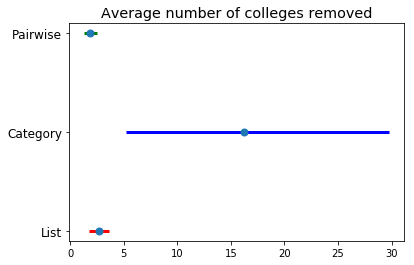

In [14]:
boot = pd.DataFrame()
for m in modes:
    boot[m] = bootstrap_mean(removes[m], 1000)
    
mean = boot.mean()
err = []
err.append((boot.apply(lambda x : np.percentile(x, (5))) - mean).abs())
err.append(boot.apply(lambda x : np.percentile(x, (95))) - mean)
plt.errorbar(mean, [0,1,2], xerr=err, fmt='o-',linestyle='none', ecolor=['red','blue','green'], elinewidth=3, markersize=7 )
plt.yticks([0,1,2], mean.index, size='large')
plt.title('Average number of colleges removed', size='x-large')
# plt.show()
plt.savefig('results/remove.png', bbox_inches='tight')

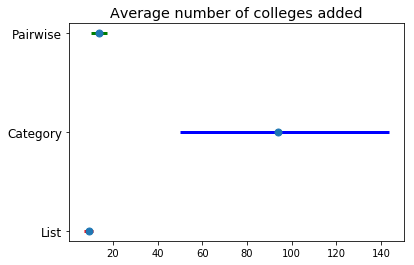

In [15]:
# use percentiles

boot = pd.DataFrame()
for m in modes:
    boot[m] = bootstrap_mean(adds[m], 1000)
mean = boot.mean()
err = []
err.append((boot.apply(lambda x : np.percentile(x, (5))) - mean).abs())
err.append(boot.apply(lambda x : np.percentile(x, (95))) - mean)
plt.errorbar(mean, [0,1,2], xerr=err, fmt='o-',linestyle='none', ecolor=['red','blue','green'], elinewidth=3, markersize=7 )
plt.yticks([0,1,2], mean.index, size='large')
plt.title('Average number of colleges added', size='x-large')
# plt.show()
plt.savefig('results/add.png', bbox_inches='tight')

In [23]:
all =[]
for m in modes:
    print(m, adds[m].mean())
    all = np.append(all, adds[m])

print(all)
print(np.std(all))

List 9.133333333333333
Category 93.125
Pairwise 13.875
[   5.    8.   12.    2.   11.    7.   21.   10.    5.    5.   13.   15.
    5.   10.    8.   12.   41.   85.    3.   48.   22.  254.   94.   12.
  231.  313.   10.  325.   15.   13.   12.    2.   16.   17.    6.    4.
    8.    9.   29.   31.   26.    2.   20.   12.   15.   17.    8.]
76.6487641559


In [16]:
# count number of time switching between build and explore
res['interaction'].unique()

array(['LOW ADD', 'HIGH ADD', 'ADD', 'SUBMIT SUCCESFUL', nan, 'QUESTION',
       'MED ADD', 'MED REMOVE', 'RANK', 'LEFT ADD', 'RIGHT ADD',
       'LOW REMOVE', 'RIGHT REMOVE', 'NEW PAIR', 'REMOVE', 'PREVIOUS',
       'FINISH TEST', 'SUBMIT FAIL', 'SORT', 'LEFT REMOVE', 'FINISH',
       'SHUFFLE', 'HIGH REMOVE'], dtype=object)

In [17]:
df =res.drop_duplicates(subset=['workerId'])
counts = df[['workerId', 'mode']].groupby(['mode']).count()
counts

,workerId
mode,
Category,16
List,15
Pairwise,15


In [18]:
counts['workerId']['List']

15

In [19]:
for m in modes:
    df = res[res['mode'] == m]
    c = df[df['interaction']=='PREVIOUS'][['workerId','interaction']].groupby('workerId').count()
    # get total number 
    num = c.shape[0]
    # adjust average to include those who don't ever iterate
    print(m)
    print(c.mean() / (counts['workerId']['List'] - num))

List
interaction    0.203704
dtype: float64
Category
interaction    0.076923
dtype: float64
Pairwise
interaction    0.277778
dtype: float64
